# Выбор криптовалюты для фарминга

В этом проекте мы проведем быстрый анализ различных криптовалютных пар для выбора наиболее привлекательных для фарминга по соотношению риск/прибыль.

При фарминге мы получаем процентный доход за удержание позиции и прибыль/убыток за разницу в цене в конце сделки. За риск примем вероятность того, что через заданный промежуток времени цена криптовалюты будет ниже текущей. За прибыль будем принимать только процентный доход за удержание позиции в процентах годовых.

Анализ проводится по сайту <https://francium.io>. Датасеты получены с сайта <https://finance.yahoo.com>

## Обзор датасета

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy. stats import norm
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [47]:
data = pd.read_csv('ETH-USD.csv', parse_dates=['Date'])
data["Number"] = data.index
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Number
0,2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,893249984,0
1,2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984,1
2,2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992,2
3,2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936,3
4,2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984,4


Мы видим стандартный для биржевых котировок набор данных с зависимостью цены от времени. Оставим для работы только цены закрытия для каждого дня.

Также для удобства добавлен столбец `Number`, чтобы можно было следить не за датой, а за относительным количеством дней с первого дня.

Далее проверим типы данных и построим график.

In [48]:
data.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
Number                int64
dtype: object

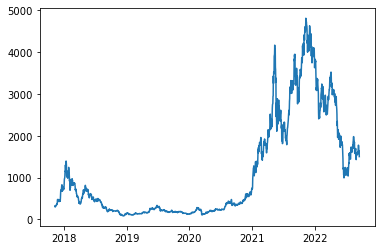

In [49]:
plt.plot(data['Date'], data['Close'])

## Нахождение тренда

Найдем линейную аппроксимацию всех точек `y = kx + b` и будем использовать коэффициент `k` для определения, на сколько в среднем долларов в день растет цена криптовалюты.

In [50]:
model = LinearRegression()
model.fit(data[["Number"]], data['Close'])
slope = float(model.coef_)
intercept = float(model.intercept_)
print(slope)
print(intercept)

1.6473129208451114
-339.44842205789473


In [51]:
data['Trend'] = data['Number'] * slope + intercept

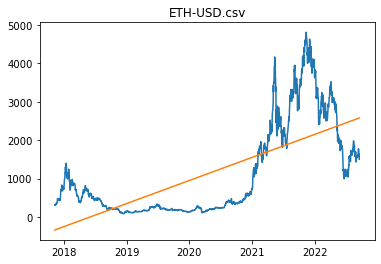

In [52]:
plt.title('ETH-USD.csv')
plt.plot(data['Date'], data['Close'])
plt.plot(data['Date'], data['Trend'])

Мы видим, что у Etherium мат.ожидание роста за каждый день составляет 1,65$

## Оценка риска

Чтобы оценить, какая вероятность получить через `n` дней цену меньше, чем текущая, воспользуемся понятиями *нормальное распределение, мат.ожидание и дисперсия*.

Измерим дисперсию за последние `n` дней - будем считать, что на протяжении следующих `n` дней волатильность будет такой же.

Для получения мат.ожидания прибавим к текущей (последней) цене `n*k` - 50\% возможных значений будут меньше и 50\% - больше.

In [53]:
### Берем цены за последний год
sample = data.iloc[-366:]['Close']

In [54]:
### Находим мат.ожидание цены через год
future_exp = sample.iloc[-1] + 365 * slope
future_exp

2104.3927511084657

In [55]:
### Находим положение текущей цены в нормальном распределении в стандартных отклонениях
z_score = (sample.iloc[-1] - future_exp) / sample.std()
z_score

-0.5828471127092688

In [67]:
### Находим вероятность того, что значение в нормальном распределении будет меньше текущей цены
risk_prob = norm.cdf(z_score)
risk_prob

0.2799981130817753

In [57]:
### Оформим вышепроведенные действия в функцию
def risk_measure(days, data):
    sample = data.iloc[-days-1:]['Close']
    slope = data.iloc[1]['Trend'] - data.iloc[0]['Trend']
    future_exp = sample.iloc[-1] + days * slope
    z_score = (sample.iloc[-1] - future_exp) / sample.std()
    risk_prob = norm.cdf(z_score)
    return risk_prob

Мы получили вероятность того, что цена Etherium через год будет ниже текущей, равную 28%.

## Оптимальный срок фарминга

Далее, измерим эту вероятность риска аналогичным образом для всего количества дней от 1 до 365, построим график и найдем минимальное значение - оптимальный срок.

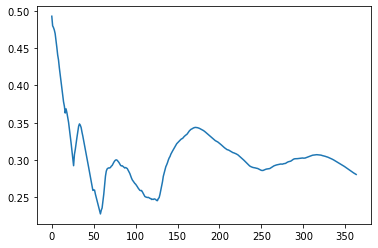

In [58]:
risks = [risk_measure(i, data) for i in range(1, 365)]
plt.plot(risks)

In [68]:
np.argmin(risks) + 1

1

In [60]:
min(risks)

0.2276608189271634

Получаем, что на данный момент для Etherium самый оптимальный по риску срок фарминга составляет 59 дней с риском 23%.

## Соотношение риск/прибыль для всех пар

Запишем криптовалютные пары и их доходности с сайта francium.io. Произведем расчеты риска и затем прибыль/риск для каждой пары.

In [61]:
### Функция для преобразования датасета
def make_data(csv_file_name):
    data = pd.read_csv(csv_file_name, parse_dates=['Date'])
    data["Number"] = data.index
    model = LinearRegression()
    model.fit(data[["Number"]], data['Close'])
    slope = float(model.coef_)
    intercept = float(model.intercept_)
    data['Trend'] = data['Number'] * slope + intercept
    return data

In [64]:
### Криптовалютные пары и их доходности (% годовых) при фарминге
coin_pairs = {'ZBC-USD.csv': [161.76], 
              'SOL-USD.csv': [19.18], 
              'STSOL-USD.csv': [24.92],
              'GENE-USD.csv': [17.75],
              'RAY-USD.csv': [19.65],
              'ETH-USD.csv': [14.17],
              'MSOL-USD.csv': [16.77],
              'ORCA-USD.csv': [1.6],
              'ATLAS-USD.csv': [5.68],
              'SHDW-USD.csv': [7.28],
              'SAMO-USD.csv': [10.89]
             }

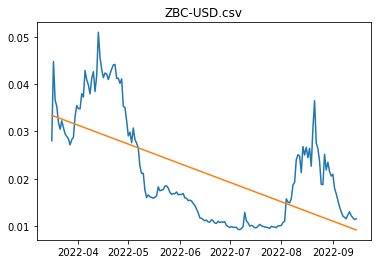

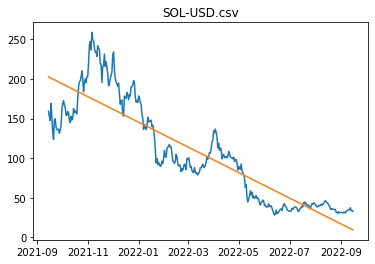

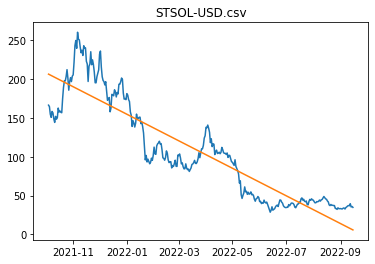

<ipython-input-57-1f2c26288a0f>:5: RuntimeWarning: divide by zero encountered in double_scalars
  z_score = (sample.iloc[-1] - future_exp) / sample.std()


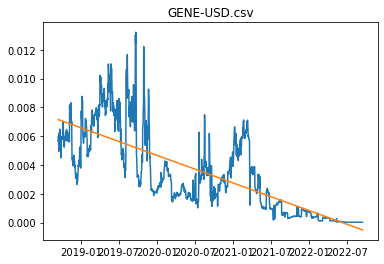

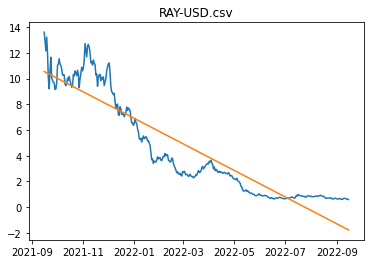

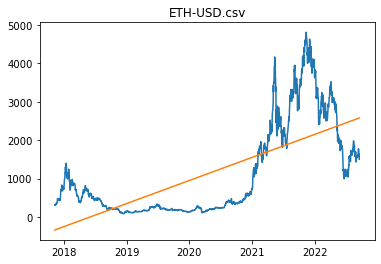

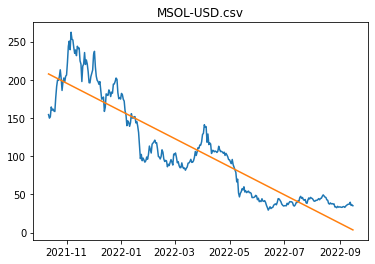

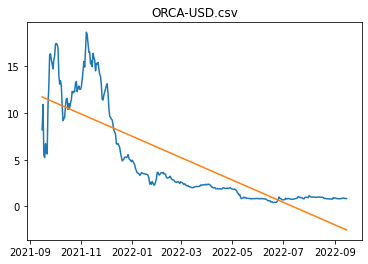

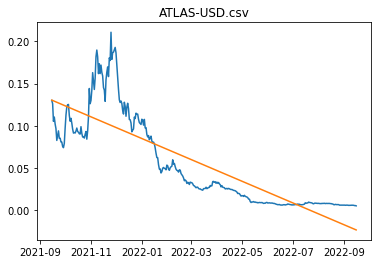

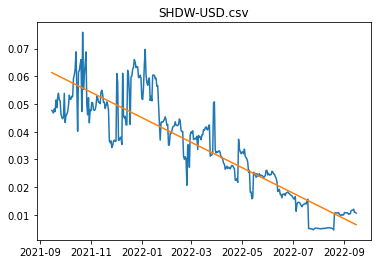

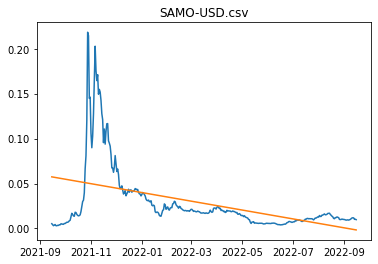

In [65]:
### Строим графики и вычисляем риск и прибыль/риск для всех пар
for key in coin_pairs.keys():
    data = make_data(key)
    risks = [risk_measure(i, data) for i in range(1, 365)]
    horizon = np.argmin(risks)
    min_risk = min(risks)
    coin_pairs[key].append(min_risk)
    coin_pairs[key].append(horizon + 1)
    coin_pairs[key].append(coin_pairs[key][0] / coin_pairs[key][1])
    
    plt.title(key)
    plt.plot(data['Date'], data['Close'])
    plt.plot(data['Date'], data['Trend'])
    plt.show()

In [66]:
coin_pairs

{'ZBC-USD.csv': [161.76, 0.6945964463283202, 26, 232.8834258439895],
 'SOL-USD.csv': [19.18, 0.7513600371311501, 1, 25.527043031504917],
 'STSOL-USD.csv': [24.92, 0.7657875040080663, 1, 32.541664455963115],
 'GENE-USD.csv': [17.75, 0.9999999869697296, 293, 17.750000231287302],
 'RAY-USD.csv': [19.65, 0.9525092988003151, 1, 20.629719861789447],
 'ETH-USD.csv': [14.17, 0.2276608189271634, 59, 62.241715841905474],
 'MSOL-USD.csv': [16.77, 0.7684783604108569, 1, 21.822345122423666],
 'ORCA-USD.csv': [1.6, 0.9970732216682976, 356, 1.6046965912121165],
 'ATLAS-USD.csv': [5.68, 0.9704599066715819, 1, 5.852895066506026],
 'SHDW-USD.csv': [7.28, 0.7615247056315648, 3, 9.559768640680392],
 'SAMO-USD.csv': [10.89, 0.6813714218675506, 1, 15.982472481971616]}

Мы видим, что пара `ETH-USD` единственная обладает восходящим трендом с начала своего запуска, поэтому имеет наименьшее значение риска `22,7%`. Наибольшую доходность при фарминге предлагает пара `ZBC-USD`, и даже с учетом не самого маленького риска она остается на первом месте по соотношению прибыль/риск.

## Выводы

Для соблюдения хотя бы минимального уровня диверсификации, я предлагаю две криптовалютные пары для фарминга:

- `ZBC-USD` как предлагающая наибольшую доходность в 161,76% годовых и обладающая приемлемым риском 69% на горизонте 26 дней.
- `ETH-USD` как обладающая наименьшим риском 23% на горизонте 59 дней и обладающая доходностью 14,17% годовых.

Распределение активов:
- 50%/50%, равные веса
- 232.88/62.24 - веса это коэффициент прибыль/риск. 79% ZBC и 21% ETH.